# 🧠 Data Science: Image Feature Extraction (GLCM)

Notebook ini mencakup seluruh tahapan tugas:
1. Pengambilan data
2. Preprocessing gambar
3. Ekstraksi fitur (GLCM)
4. Simpan hasil ke CSV

⚙️ Sudah dilengkapi otomatisasi instalasi dependensi agar tidak error di Google Colab lokal.

In [1]:
import sys
!"{sys.executable}" -m pip install numpy==1.26.4 scipy==1.13.1 scikit-image==0.24.0 --force-reinstall --no-cache-dir
import torch
print("✅ PyTorch:", torch.__version__)
print("💻 CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("🧠 GPU:", torch.cuda.get_device_name(0))


   ---------------------------------------- 0.0/15.8 MB ? eta -:--:--
   - -------------------------------------- 0.5/15.8 MB 2.1 MB/s eta 0:00:08
   --- ------------------------------------ 1.3/15.8 MB 3.0 MB/s eta 0:00:05
   ---- ----------------------------------- 1.8/15.8 MB 2.9 MB/s eta 0:00:05
   ----- ---------------------------------- 2.4/15.8 MB 2.8 MB/s eta 0:00:05
   ------ --------------------------------- 2.6/15.8 MB 2.8 MB/s eta 0:00:05
   -------- ------------------------------- 3.4/15.8 MB 2.7 MB/s eta 0:00:05
   --------- ------------------------------ 3.9/15.8 MB 2.7 MB/s eta 0:00:05
   ----------- ---------------------------- 4.5/15.8 MB 2.7 MB/s eta 0:00:05
   ------------- -------------------------- 5.2/15.8 MB 2.8 MB/s eta 0:00:04
   -------------- ------------------------- 5.8/15.8 MB 2.8 MB/s eta 0:00:04
   ---------------- ----------------------- 6.6/15.8 MB 2.8 MB/s eta 0:00:04
   ----------------- ---------------------- 7.1/15.8 MB 2.9 MB/s eta 0:00:04
   ---

In [ ]:
import sys
!"{sys.executable}" -m pip uninstall -y numpy
!"{sys.executable}" -m pip install numpy==1.26.4 scipy==1.13.1 scikit-image==0.24.0 --force-reinstall --no-cache-dir
import cv2, numpy, pandas, torch
print("✅ Semua library siap jalan")
print("OpenCV:", cv2.__version__)
print("NumPy:", numpy.__version__)
print("Pandas:", pandas.__version__)
print("PyTorch:", torch.__version__)


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
   ---------------------------------------- 0.0/15.8 MB ? eta -:--:--
   - -------------------------------------- 0.5/15.8 MB 5.6 MB/s eta 0:00:03
   --- ------------------------------------ 1.3/15.8 MB 3.5 MB/s eta 0:00:05
   ----- ---------------------------------- 2.1/15.8 MB 3.7 MB/s eta 0:00:04
   ----- ---------------------------------- 2.4/15.8 MB 3.5 MB/s eta 0:00:04
   -------- ------------------------------- 3.4/15.8 MB 3.4 MB/s eta 0:00:04
   --------- ------------------------------ 3.9/15.8 MB 3.6 MB/s eta 0:00:04
   ----------- ---------------------------- 4.7/15.8 MB 3.4 MB/s eta 0:00:04
   ------------- -------------------------- 5.5/15.8 MB 3.5 MB/s eta 0:00:03
   --------------- ------------------------ 6.3/15.8 MB 3.5 MB/s eta 0:00:03
   ----------------- ---------------------- 7.1/15.8 MB 3.5 MB/s eta 0:00:03
   ------------------- -------------------- 7.6/15.

## 📦 Import library dan cek GPU

In [ ]:
!pip install numpy==1.26.4 scipy==1.13.1 scikit-image==0.24.0 --force-reinstall
import torch, cv2, os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops
from tqdm import tqdm

print('🧠 PyTorch:', torch.__version__)
print('🧩 CUDA available:', torch.cuda.is_available())

  Using cached numpy-1.26.4-cp310-cp310-win_amd64.whl.metadata (61 kB)
  Using cached scipy-1.13.1-cp310-cp310-win_amd64.whl.metadata (60 kB)
  Using cached scikit_image-0.24.0-cp310-cp310-win_amd64.whl.metadata (14 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached pillow-12.0.0-cp310-cp310-win_amd64.whl.metadata (9.0 kB)
  Using cached imageio-2.37.0-py3-none-any.whl.metadata (5.2 kB)
  Using cached tifffile-2025.5.10-py3-none-any.whl.metadata (31 kB)
  Using cached packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
Using cached numpy-1.26.4-cp310-cp310-win_amd64.whl (15.8 MB)
Using cached scipy-1.13.1-cp310-cp310-win_amd64.whl (46.2 MB)
Using cached scikit_image-0.24.0-cp310-cp310-win_amd64.whl (12.9 MB)
Using cached imageio-2.37.0-py3-none-any.whl (315 kB)
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
Using cached networkx-3.4.2-py3-none-any.whl (1.7 MB)
Using cached packaging-

## 📁 Ambil data gambar dari CIFAR-10 (contoh dataset publik)

Files already downloaded and verified
Jumlah gambar: 50000


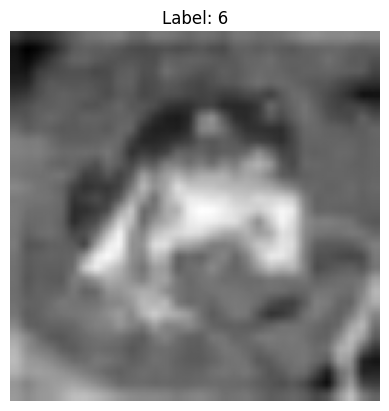

In [ ]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

dataset = datasets.CIFAR10(root='./data', download=True, transform=transform)
print('Jumlah gambar:', len(dataset))

# tampilkan contoh gambar
img, label = dataset[0]
plt.imshow(img[0], cmap='gray')
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()

## 🧹 Ekstraksi fitur GLCM

In [ ]:
def extract_glcm_features(image):
    img_uint8 = (image * 255).astype('uint8')
    glcm = graycomatrix(img_uint8, distances=[1], angles=[0], symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    return [contrast, energy, homogeneity, correlation]

features = []
labels = []

for i in tqdm(range(2000)):  # 2000 gambar
    img, label = dataset[i]
    feat = extract_glcm_features(img[0].numpy())
    features.append(feat)
    labels.append(label)

df = pd.DataFrame(features, columns=['contrast', 'energy', 'homogeneity', 'correlation'])
df['label'] = labels
df.head()

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 630.29it/s]


,contrast,energy,homogeneity,correlation,label
0,27.373524,0.034866,0.333937,0.990893,6
1,44.647761,0.018199,0.252349,0.993045,9
2,27.694636,0.122485,0.520524,0.997913,9
3,15.070374,0.040608,0.373525,0.992285,4
4,28.562746,0.039863,0.475991,0.995239,1


## 💾 Simpan hasil fitur ke CSV

In [ ]:
df.to_csv('glcm_features.csv', index=False)
print('✅ Fitur GLCM berhasil disimpan ke glcm_features.csv')

✅ Fitur GLCM berhasil disimpan ke glcm_features.csv
